# Template 

### Import Packages

In [0]:
#importing some useful packages
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline


### Read image folder and chose Image

In [0]:
os.listdir("test_images/")


['carrilBCN.jpg',
 'carrilBCN2.jpg',
 'carrilCadiz.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

This image height is: 768 and the width: 1024


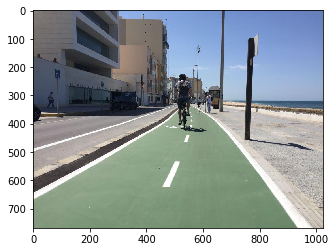

In [0]:

image = mpimg.imread('test_images/carrilCadiz.jpg')

#printing out some stats and plotting
height, width = image.shape[:2]
print('This image height is:', height, 'and the width:', width)
plt.imshow(image)

### Helper Functions 

In [0]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
        
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Lane Finding Pipeline
To find Lane we'll use Canny to detect edges in a pre-process gray image, with these Edges we going to use Hough Transformation to find lines we'll use to draw in image. 


To reach our objective we going throught some steps:

* Create a Grayscale image
* Apply blur to avoid noise
* Find Edges Using Canny
* Define Vertices to create a Region of Interest
* Use Hough Transformation to find Lines
* Merge Lines and original image
* Create a pipeline function
* Test with test images

### Create a Grayscale image

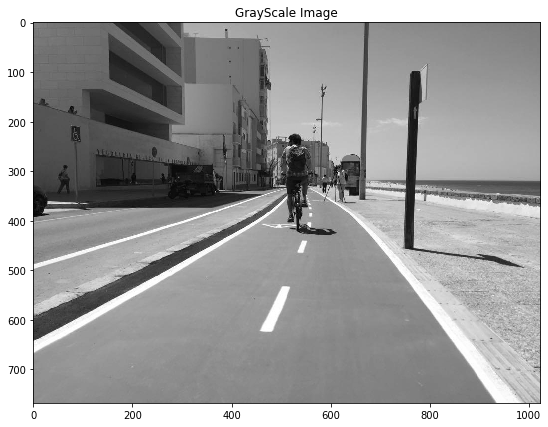

In [0]:
gray = grayscale(image)
plt.figure(figsize=(10,7))
plt.title("GrayScale Image")
plt.imshow(gray, cmap='gray')


### Apply blur to avoid noise

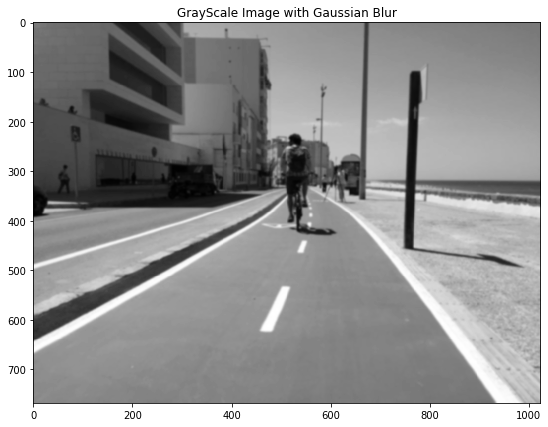

In [0]:
kernel_size = 9 # Kernel size
blur_gray = gaussian_blur(gray, kernel_size)
plt.figure(figsize=(10,7))
plt.title("GrayScale Image with Gaussian Blur")
plt.imshow(blur_gray, cmap='gray')

## Finding Edges Using Canny

### Set the parameters to Canny Edges Detection

These parameters set the edge detection sensibility

In [0]:
low_threshold = 100
high_threshold = 200

### Using Canny Detection


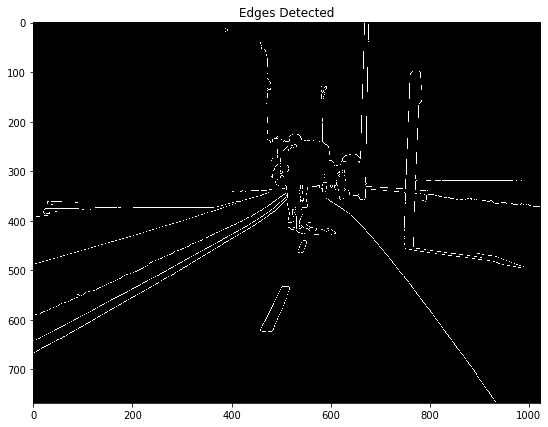

In [0]:
edges = canny(blur_gray, low_threshold, high_threshold)
plt.figure(figsize=(10,7))
plt.title("Edges Detected")
plt.imshow(edges, cmap='Greys_r')

## Region of Interest


### Definition of vertices

In [0]:
vertex1=(0,height)
vertex2=(0,500)
vertex3=(450, 400)
vertex4=(650, 400)
vertex5=(width,500)
vertex6=(width,height)

### Creating the region of interest

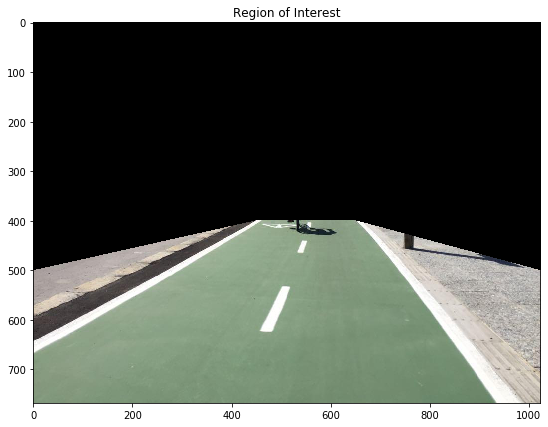

In [0]:
vertices = np.array([[vertex1,vertex2,vertex3, vertex4, vertex5,vertex6]], dtype=np.int32)
mask = region_of_interest(image, vertices)
plt.figure(figsize=(10,7))
plt.title("Region of Interest")
plt.imshow(mask, cmap='Greys_r')

### Vertices of the region of interest

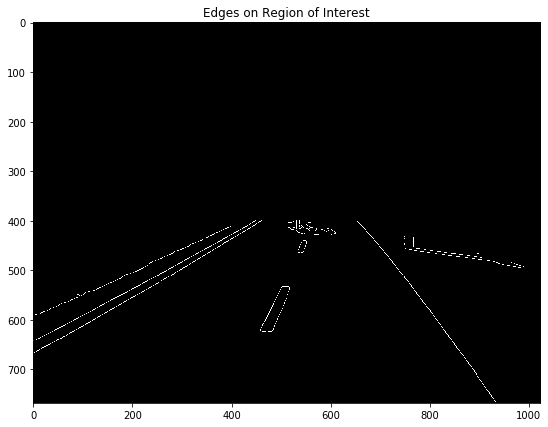

In [0]:
masked_edges = region_of_interest(edges, vertices)
plt.figure(figsize=(10,7))
plt.title("Edges on Region of Interest")
plt.imshow(masked_edges, cmap='Greys_r')

## Use Hough Transformation to find Lines

To use Hough Transformation we must set some parameters:

* rho and theta are the distance and angular resolution of our grid in Hough space. Remember that, in Hough space, we have a grid laid out along the (Θ, ρ) axis. 


* Threshold parameter specifies the minimum number of votes (intersections in a given grid cell) a candidate line needs to have to make it into the output. 


* min_line_length is the minimum length of a line (in pixels) that you will accept in the output


* max_line_gap is the maximum distance (again, in pixels) between segments that you will allow to be connected into a single line.

Adittionally, we set some parameters to detect the to lines of the road

* y_bottom_test is the lower value of the mask


* y_upper_test is the higher value of the mask 


* min_slope_test is the min slope permited as road line


* max_slope_test is the max slope permited as road line

In [0]:
rho = 1
theta = np.pi/180
threshold = 50
min_line_len = 20
max_line_gap = 10
y_bottom_test = height
y_upper_test = 400
min_slope_test = 0.2
max_slope_test = 2

In [0]:
lines_detected = 0

## Function to detect the road lines

In [0]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    
    global lines_detected
    
     #list to get positives and negatives values
    x_bottom_pos = []
    x_upperr_pos = []
    x_bottom_neg = []
    x_upperr_neg = []
    
    y_bottom = y_bottom_test
    y_upperr = y_upper_test
    
    #y1 = slope*x1 + b
    #b = y1 - slope*x1 
    #y = slope*x + b
    #x = (y - b)/slope
    
    slope = 0
    b = 0
    right_line = False
    left_line = False
    #get x upper and bottom to lines with slope positive and negative    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #test and filter values to slope
            if ((y2-y1)/(x2-x1)) > min_slope_test and ((y2-y1)/(x2-x1)) < max_slope_test :
                if right_line==False :
                    right_line=True
                    
                slope = ((y2-y1)/(x2-x1))
                b = y1 - slope*x1
                
                x_bottom_pos.append((y_bottom - b)/slope)
                x_upperr_pos.append((y_upperr - b)/slope)
                                      
            elif ((y2-y1)/(x2-x1)) < -min_slope_test and ((y2-y1)/(x2-x1)) > -max_slope_test:
                if left_line==False :
                    left_line=True
                
                slope = ((y2-y1)/(x2-x1))
                b = y1 - slope*x1
                
                x_bottom_neg.append((y_bottom - b)/slope)
                x_upperr_neg.append((y_upperr - b)/slope)
                    
    if right_line == True :
        lines_mean_pos = np.array([int(np.mean(x_bottom_pos)), int(np.mean(y_bottom)), int(np.mean(x_upperr_pos)), int(np.mean(y_upperr))])
        lines_detected = 1
        
    if left_line == True :
        lines_mean_neg =  np.array([int(np.mean(x_bottom_neg)), int(np.mean(y_bottom)), int(np.mean(x_upperr_neg)), int(np.mean(y_upperr))])
        lines_detected = 1
        
    if right_line == True or left_line == True :
        if right_line == True and left_line == True :
            lines_detected = 2
            lines_mean = np.array([lines_mean_pos,lines_mean_neg])
        elif right_line == True :
            lines_mean = right_line
        else :
            lines_mean = left_line
    
    return lines_mean

In [0]:
lines_hough = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
lines_hough


array([[[180, 549, 449, 400]],

       [[231, 538, 459, 401]],

       [[697, 449, 808, 591]],

       [[255, 478, 399, 411]],

       [[119, 542, 233, 489]],

       [[ 75, 625, 229, 539]],

       [[757, 458, 908, 479]],

       [[  1, 667, 136, 592]],

       [[762, 533, 824, 613]],

       [[768, 455, 905, 474]],

       [[110, 586, 200, 537]],

       [[866, 671, 933, 766]],

       [[458, 619, 502, 533]],

       [[  4, 641, 290, 489]],

       [[808, 593, 837, 631]],

       [[482, 622, 517, 539]],

       [[658, 406, 721, 478]],

       [[  4, 590, 101, 549]],

       [[859, 662, 914, 740]],

       [[541, 426, 592, 429]],

       [[936, 485, 988, 495]],

       [[869, 473, 933, 483]],

       [[172, 570, 259, 521]]], dtype=int32)

In [0]:
lines2 = draw_lines(masked_edges, lines_hough, color=[255, 0, 0], thickness=7)
print(lines2)

[[ 945  768  663  400]
 [-194  768  465  400]]


In [0]:
lines_detected

2

In [0]:
line_img = np.zeros((height, width, 3), dtype=np.uint8)
for i in range(len(lines)):
        cv2.line(line_img, (lines2[i,0], lines2[i,1]), (lines2[i,2], lines2[i,3]), [255, 0, 0], 7)

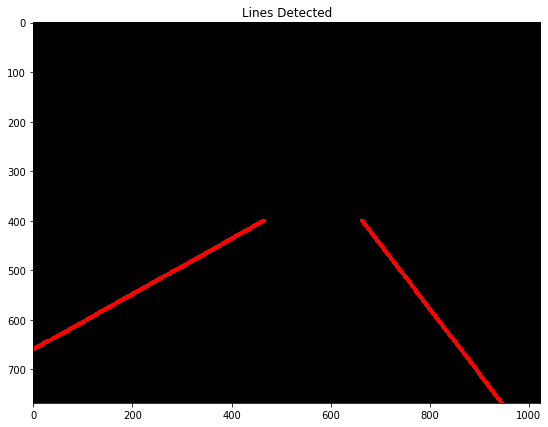

In [0]:
plt.figure(figsize=(10,7))
plt.title("Lines Detected")
plt.imshow(line_img)

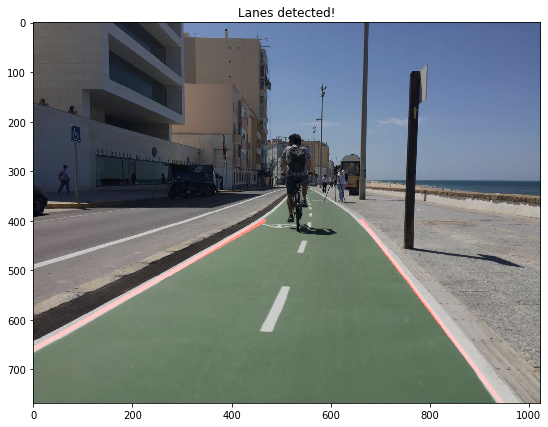

In [0]:
lines_edges = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
plt.figure(figsize=(10,7))
plt.title("Lanes detected!")
plt.imshow(lines_edges)